In [4]:
!pip install tensorflow

In [7]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#import nltk
#nltk.download('stopwords')

from nltk.corpus import stopwords


STOPWORDS = set(stopwords.words('english'))

print(tf.__version__)

2.4.0


In [8]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [10]:
articles = []
labels = []

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


In [11]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

1780
1780
1780
445
445


In [12]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'said': 2,
 'mr': 3,
 'would': 4,
 'year': 5,
 'also': 6,
 'people': 7,
 'new': 8,
 'us': 9,
 'one': 10}

In [13]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[2432, 1, 225, 4995, 22, 642, 586, 225, 4995, 1, 1, 1662, 1, 1, 2432, 22, 564, 1, 1, 140, 278, 1, 140, 278, 796, 823, 662, 2308, 1, 1145, 1693, 1, 1720, 4996, 1, 1, 1, 1, 1, 4737, 1, 1, 122, 4513, 1, 2, 2875, 1506, 352, 4738, 1, 52, 341, 1, 352, 2173, 3962, 41, 22, 3793, 1, 1, 1, 1, 542, 1, 1, 1, 835, 631, 2367, 347, 4739, 1, 365, 22, 1, 787, 2368, 1, 4301, 138, 10, 1, 3663, 682, 3531, 1, 22, 1, 414, 823, 662, 1, 90, 13, 633, 1, 225, 4995, 1, 598, 1, 1693, 1022, 1, 4997, 807, 1864, 117, 1, 1, 1, 2975, 22, 1, 99, 278, 1, 1607, 4998, 542, 492, 1, 1443, 4740, 778, 1320, 1, 1861, 10, 33, 642, 319, 1, 62, 478, 564, 301, 1507, 22, 479, 1, 1, 1665, 1, 797, 1, 3067, 1, 1365, 6, 1, 2432, 564, 22, 2972, 4734, 1, 1, 1, 1, 1, 850, 39, 1824, 675, 297, 26, 979, 1, 882, 22, 361, 22, 13, 301, 1507, 1343, 374, 20, 63, 883, 1097, 4302, 247]


In [14]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [15]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [16]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [17]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 394,694
Trainable params: 394,694
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
56/56 - 10s - loss: 1.5653 - accuracy: 0.3180 - val_loss: 1.4443 - val_accuracy: 0.4337
Epoch 2/10
56/56 - 5s - loss: 1.0774 - accuracy: 0.5410 - val_loss: 0.8262 - val_accuracy: 0.6247
Epoch 3/10
56/56 - 5s - loss: 0.5018 - accuracy: 0.8174 - val_loss: 0.4092 - val_accuracy: 0.8674
Epoch 4/10
56/56 - 5s - loss: 0.3982 - accuracy: 0.8511 - val_loss: 0.3844 - val_accuracy: 0.8629
Epoch 5/10
56/56 - 5s - loss: 0.1258 - accuracy: 0.9584 - val_loss: 0.2258 - val_accuracy: 0.9281
Epoch 6/10
56/56 - 5s - loss: 0.0283 - accuracy: 0.9944 - val_loss: 0.2753 - val_accuracy: 0.9124
Epoch 7/10
56/56 - 5s - loss: 0.0173 - accuracy: 0.9989 - val_loss: 0.2287 - val_accuracy: 0.9303
Epoch 8/10
56/56 - 5s - loss: 0.0062 - accuracy: 0.9989 - val_loss: 0.2624 - val_accuracy: 0.9213
Epoch 9/10
56/56 - 5s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.2857 - val_accuracy: 0.9236
Epoch 10/10
56/56 - 5s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2849 - val_accuracy: 0.9258


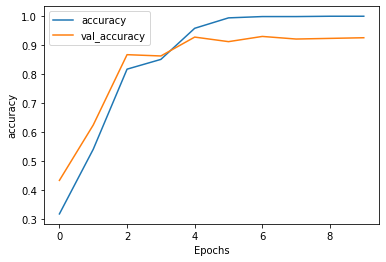

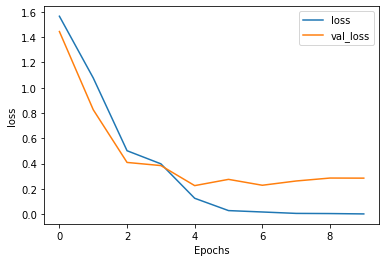

In [21]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")